# Explaining logistic regression model predictions with Shapley values

Shapley values provide an estimate of how much any particular feature influences the model decision. When Shapley values are averaged they provide a measure of the overall influence of a feature.

Shapley values may be used across model types, and so provide a model-agnostic measure of a feature’s influence. This means that the influence of features may be compared across model types, and it allows black box models like neural networks to be explained, at least in part.

For more on Shapley values in general see Chris Molner’s excellent book chapter:

https://christophm.github.io/interpretable-ml-book/shapley.html


More information on the shap library, inclusiong lots of useful examples may be found at: https://shap.readthedocs.io/en/latest/index.html

Here we provide an example of using shap with logistic regression.

## Load packages

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

## Load data

We will use the first train/test split.

In [2]:
data_loc = '../../data/sam_1/kfold_5fold/'

train = pd.read_csv(data_loc + 'train_0.csv')
test = pd.read_csv(data_loc + 'test_0.csv')

## Function to standardise data

In [3]:
def standardise_data(X_train, X_test):
    """
    Converts all data to a similar scale.
    Standardisation subtracts mean and divides by standard deviation
    for each feature.
    Standardised data will have a mena of 0 and standard deviation of 1.
    The training data mean and standard deviation is used to standardise both
    training and test set data.
    """
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

## Fit logistic regression model

Fit model and get feature weights (coefficients).

In [4]:
# Get X and y
X_train = train.drop('S2Thrombolysis', axis=1)
X_test = test.drop('S2Thrombolysis', axis=1)
y_train = train['S2Thrombolysis']
y_test = test['S2Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['StrokeTeam'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('StrokeTeam', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['StrokeTeam'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('StrokeTeam', axis=1, inplace=True)

# Standardise X data
X_train_std, X_test_std = standardise_data(X_train, X_test)

# Define and Fit model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_std, y_train)

# Get feature weights
features = list(X_train)
feature_weights = model.coef_[0]
weights = pd.DataFrame(index=features)
weights['weights'] = feature_weights
weights['abs_weights'] = np.abs(feature_weights)
weights['rank'] = weights['abs_weights'].rank(ascending=False).values

# Get predicted class and ptrobability
y_pred = model.predict(X_test_std)
y_prob = model.predict_proba(X_test_std)[:, 1]

# Measure accuracy
accuracy = np.mean(y_pred == y_test)
print(f'Accuracy: {accuracy:0.3f}')

Accuracy: 0.831


## Shap values

### Get Shap values

We will get the Shap values for the test set.

In [5]:
# We pass data to Shap as a DataFrame with feature names
X_train_std_df = pd.DataFrame(X_train_std, columns=list(X_train))
X_test_std_df = pd.DataFrame(X_test_std, columns=list(X_train))

# Set up explainer using typical feature values from training set
# Note: Use a sample of 100-1000 for this if explainer too slow
explainer = shap.Explainer(model, X_train_std_df)

# To get Shapley values for test set alone:
#shap_values = explainer.shap_values(X_test_std_df)

# Get Shapley values along with base and features
shap_values_extended = explainer(X_test_std_df)
shap_values = shap_values_extended.values

# Get mean Shap values for each feature
shap_values_mean = pd.DataFrame(index=features)
shap_values_mean['mean_shap'] = np.mean(shap_values, axis=0)
shap_values_mean['abs_mean_shap'] = np.abs(shap_values_mean)
shap_values_mean['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
shap_values_mean['rank'] = shap_values_mean['mean_abs_shap'].rank(
    ascending=False).values

### Compare top 10 weights and Shap values

In [6]:
top_10_weights = weights.sort_values('abs_weights', ascending=False).head(10)
top_10_weights

,weights,abs_weights,rank
S2BrainImagingTime_min,-18.407621,18.407621,1.0
S2StrokeType_Infarction,2.649371,2.649371,2.0
S2StrokeType_Primary Intracerebral Haemorrhage,-2.644069,2.644069,3.0
S2RankinBeforeStroke,-0.503195,0.503195,4.0
AFAnticoagulent_Yes,-0.394638,0.394638,5.0
Loc,-0.374935,0.374935,6.0
BestLanguage,0.306445,0.306445,7.0
S1OnsetTimeType_Precise,0.292375,0.292375,8.0
S1OnsetTimeType_Best estimate,-0.292375,0.292375,9.0
S1OnsetDateType_Stroke during sleep,-0.290345,0.290345,10.0


When looking for the most influential Shap values we use the mean of the absolute Shap values for each feature.

In [7]:
top_10_shap = shap_values_mean.sort_values(
    'mean_abs_shap', ascending=False).head(10)
top_10_shap

,mean_shap,abs_mean_shap,mean_abs_shap,rank
S2BrainImagingTime_min,-1.096812,1.096812,2.307967,1.0
S2StrokeType_Infarction,0.380828,0.380828,2.139826,2.0
S2StrokeType_Primary Intracerebral Haemorrhage,0.392925,0.392925,2.137777,3.0
S2RankinBeforeStroke,-0.037584,0.037584,0.405996,4.0
S1OnsetTimeType_Precise,0.013593,0.013593,0.286391,5.0
S1OnsetTimeType_Best estimate,0.013593,0.013593,0.286391,6.0
AFAnticoagulent_Yes,0.009187,0.009187,0.266622,7.0
BestLanguage,0.050849,0.050849,0.258668,8.0
Loc,-0.028140,0.028140,0.230644,9.0
S1OnsetToArrival_min,-0.024913,0.024913,0.220878,10.0


Get intersection between top 10 weights and top 10 Shap values.

In [8]:
intersection = list(top_10_weights.index.intersection(top_10_shap.index))
print(f'Number of intersection values = {len(intersection)}')
print('\nIntersecting values:')
intersection

Number of intersection values = 9

Intersecting values:


['S2BrainImagingTime_min',
 'S2StrokeType_Infarction',
 'S2StrokeType_Primary Intracerebral Haemorrhage',
 'S2RankinBeforeStroke',
 'AFAnticoagulent_Yes',
 'Loc',
 'BestLanguage',
 'S1OnsetTimeType_Precise',
 'S1OnsetTimeType_Best estimate']

### Plot average Shap values against average weights

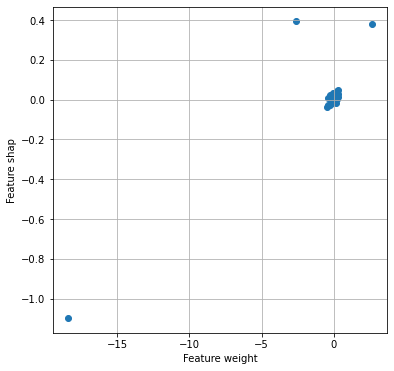

In [9]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(weights['weights'], shap_values_mean['mean_shap'])
ax.grid()
ax.set_xlabel('Feature weight')
ax.set_ylabel('Feature shap')
plt.show()

### Plot most influential features

This is a plot of the mean ansolute Shap values.

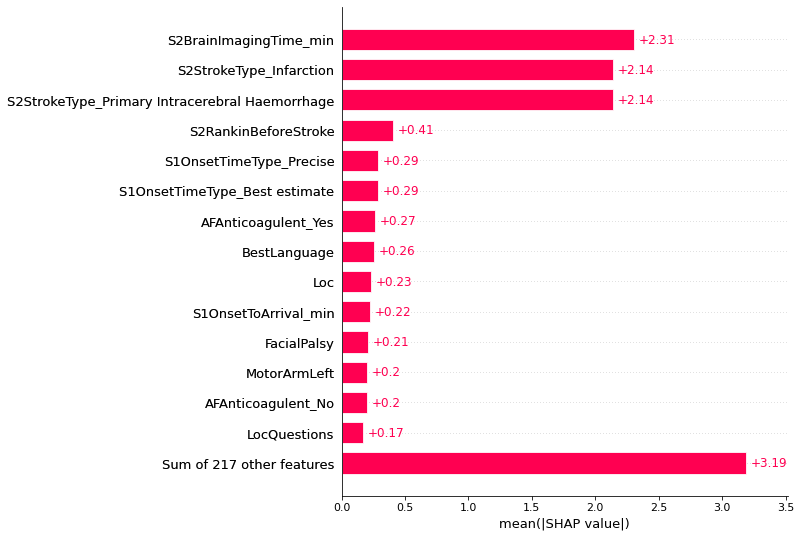

In [10]:
shap.plots.bar(shap_values_extended, max_display=15) # default is max_display=12

### Bar chart for individual case

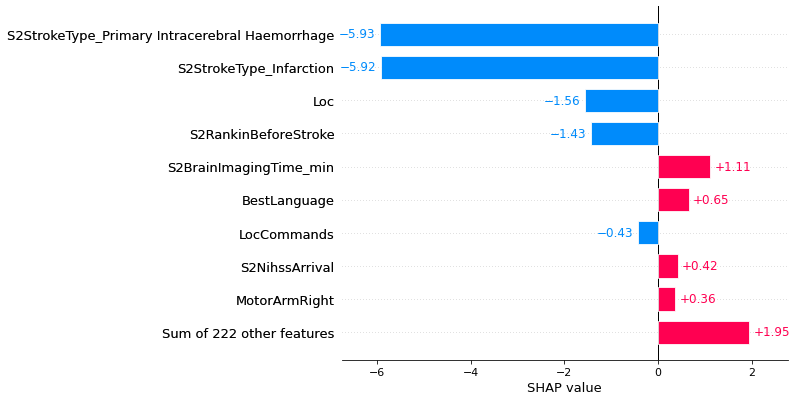

In [11]:
shap.plots.bar(shap_values_extended[0]) # For the first observation

### Beeswarm plot

A Beeswarm plot shows all points. The feature value for each point is shown by the colour, and its position indicates the Shap value for that instance.

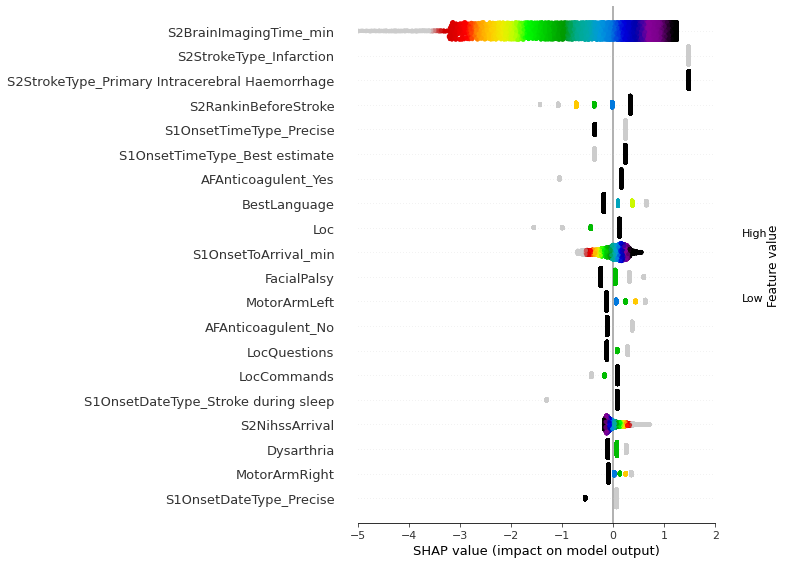

In [12]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values=shap_values, 
                  features=X_test_std,
                  feature_names=features, 
                  cmap=plt.get_cmap('nipy_spectral'),show=False)
# Truncate x axis
plt.xlim(-5,2)
plt.show()

### Plot Waterfall and decision plot plots for instances with low or high probability of receiving thrombolysis

Waterfall plot and decision plots are alternative ways of plotting the influence of features for individual cases.

In [13]:
# Get the location of an example each where porbability of giving thrombolysis
# is <0.01 or >0.99

location_low_probability = np.where(y_prob < 0.01)[0][0]
location_high_probability = np.where(y_prob > 0.99)[0][0]

Example of a person with low probability of receiving thrombolysis.

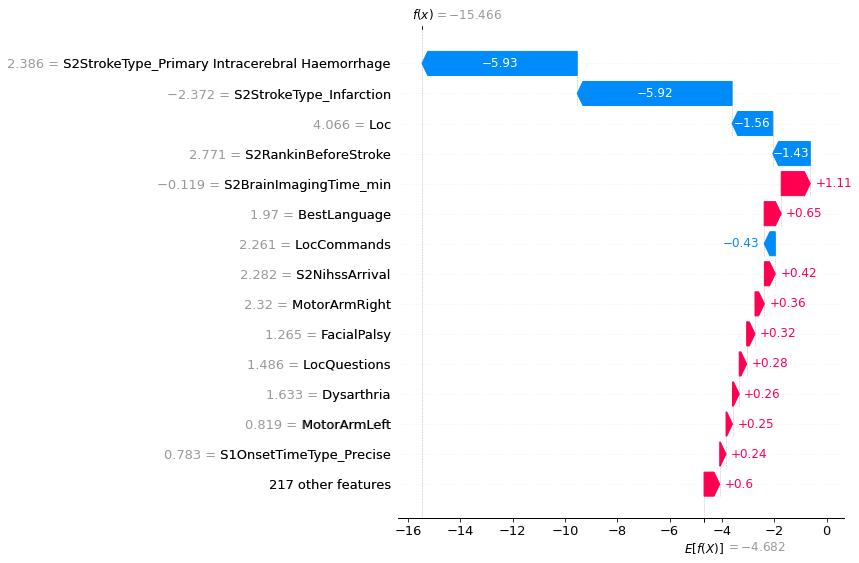

In [14]:
shap.plots.waterfall(shap_values_extended[location_low_probability], 
                     max_display=15)

The base value is -4.68
Chart is dislaying in brackets the standardised feature values (model was trained on standardised values)


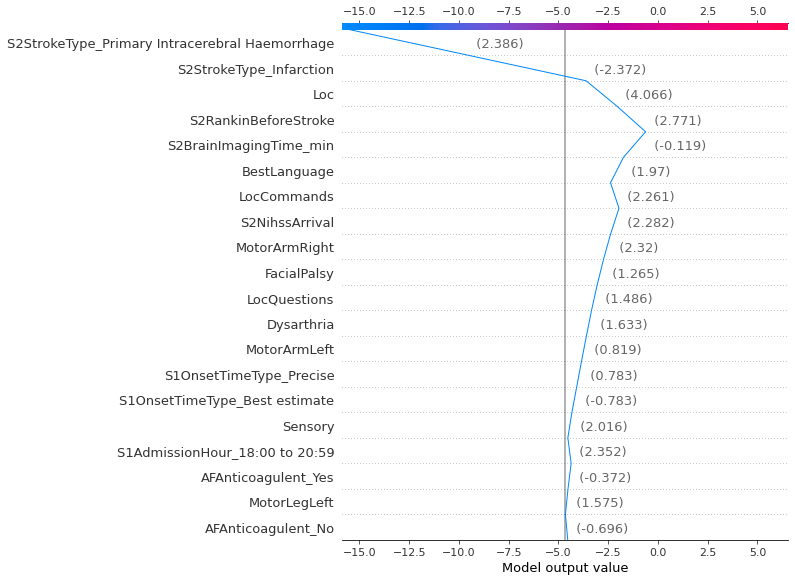

In [15]:
instance = location_low_probability

chosen_instance = X_test_std_df.iloc[instance]
shap_values_instance = shap_values[instance]
expected_value = shap_values_extended.base_values[0]#explainer.expected_value
print(f"The base value is {expected_value:0.2f}")
print(f"Chart is dislaying in brackets the standardised feature values (model was trained on standardised values)")

shap.decision_plot(expected_value, shap_values_instance, chosen_instance)

Example of a person high low probability of receiving thrombolysis.

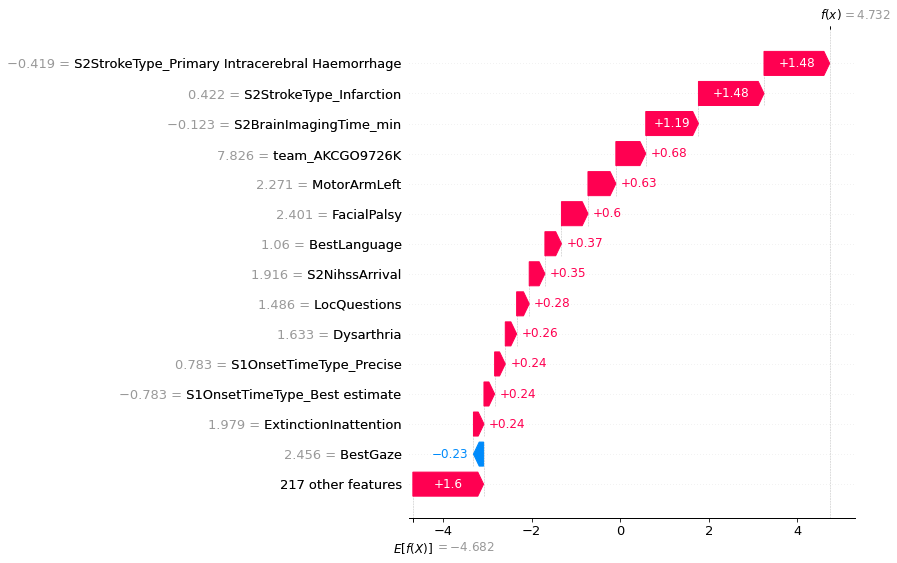

In [16]:
shap.plots.waterfall(shap_values_extended[location_high_probability], 
                     max_display=15)

The base value is -4.68
Chart is dislaying in brackets the standardised feature values (model was trained on standardised values)


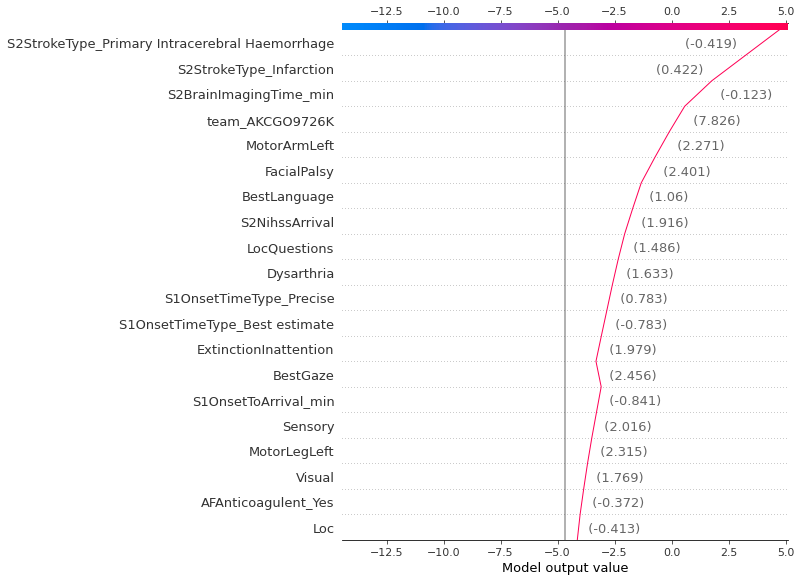

In [17]:
instance = location_high_probability

chosen_instance = X_test_std_df.iloc[instance]
shap_values_instance = shap_values[instance]
expected_value = shap_values_extended.base_values[0]#explainer.expected_value
print(f"The base value is {expected_value:0.2f}")
print(f"Chart is dislaying in brackets the standardised feature values (model was trained on standardised values)")

shap.decision_plot(expected_value, shap_values_instance, chosen_instance)

### Show the relationship between feature value and Shap value for top 10 influential features.

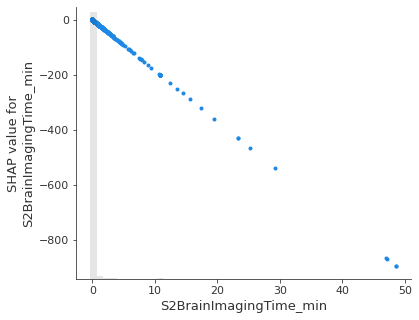

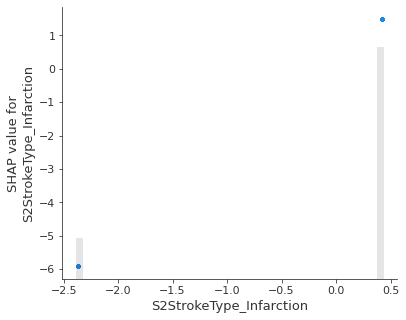

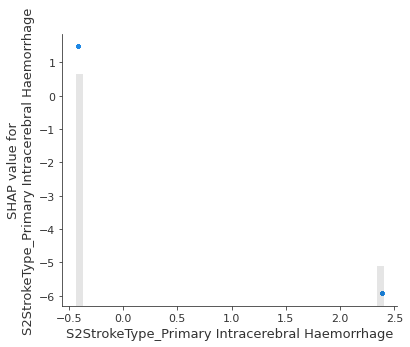

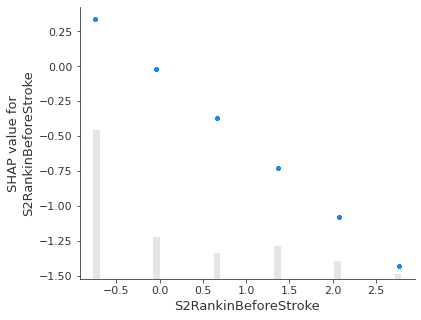

In [18]:
feat_to_show = top_10_shap.index[0:4]

for feat in feat_to_show:
    shap.plots.scatter(shap_values_extended[:, feat], x_jitter=0)